In [1]:
from mimic.utilities import *
from mimic.utilities.utilities import plot_CRM

from mimic.model_infer.infer_CRM_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_CRM import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle

from scipy import stats
from scipy.integrate import odeint




## Bayesian inference to infer the parameters of a Consumer Resource model

The Consumer Resource equation based on the MacArthur model takes the form

$$
dN_i = \frac{N_i}{\tau} \cdot \left( c_{ij} \cdot (w \cdot R)_j - m_i \right)
$$

$$
dR_j = \frac{1}{r \cdot K_j} \cdot (K_j - R_j) \cdot R_j - (N_i \cdot c_{ij} \cdot R_j)
$$


where:
-   $N$ is the concentration of each species
-   $\tau$ is the species timescale
-   $m$ is the species mortality rate
-   $R$ is the concentration of each resource
-   $r$ is the resource timescale
-   $w$ is the quality of each resource
-   $K$ is the resource capacity
-   $c$ is each species' preference for each resource



Unlike the gLV, the CRM is not linearised, so the DifferentialEquation function from pymc is utilised to solve the ODEs within the inference function. This can take a while if inferring all parameters, so below we demonstrate two features of the run_inference: inferring only one parameter (c) while the rest remain fixed, and inferring all parameters, although this takes longer.

## Read in simulated data
The data was simulated examples-sim-CRM.ipynb

In [2]:
with open("params-s2-r2.pkl", "rb") as f:
    params = pickle.load(f)
tau = params["tau"]
m = params["m"]
r = params["r"]
w = params["w"]
K = params["K"]
c = params["c"]

# read in the data

data = pd.read_csv("data-s2-r2.csv")

times = data.iloc[:, 0].values
yobs = data.iloc[:, 1:6].values

## Infer parameter c only
While parameters tau, m, r, w and K remain fixed to true values generated by the simulation

times shape: (100,)
yobs shape: (100, 4)
Number of species: 2
Number of resources: 2


Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


tau_hat is fixed
w_hat is fixed
c_hat is inferred
m_hat is fixed
r_hat is fixed
K_hat is fixed
Initial parameter values: {'sigma_log__': array([0.]), 'c_hat_vals_interval__': array([[0., 0.],
       [0., 0.]])}
Shape of tau_hat: [2]
Shape of w_hat: [2]
Shape of c_hat: [2 2]
Shape of m_hat: [2]
Shape of r_hat: [2]
Shape of K_hat: [2]
Shape of nr_tensor: [1]
Shape of nsp_tensor: [1]
Shape of theta: [16]
Shape of yobs: (100, 4)
Shape of crm_curves: [100   4]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c_hat_vals]


Output()

Sampling 4 chains for 20 tune and 20 draw iterations (80 + 80 draws total) took 90 seconds.
The number of samples is too small to check convergence reliably.


Parameter tau_hat not found in posterior samples, skipping plot.
Parameter w_hat not found in posterior samples, skipping plot.
Plotting posterior for c_hat


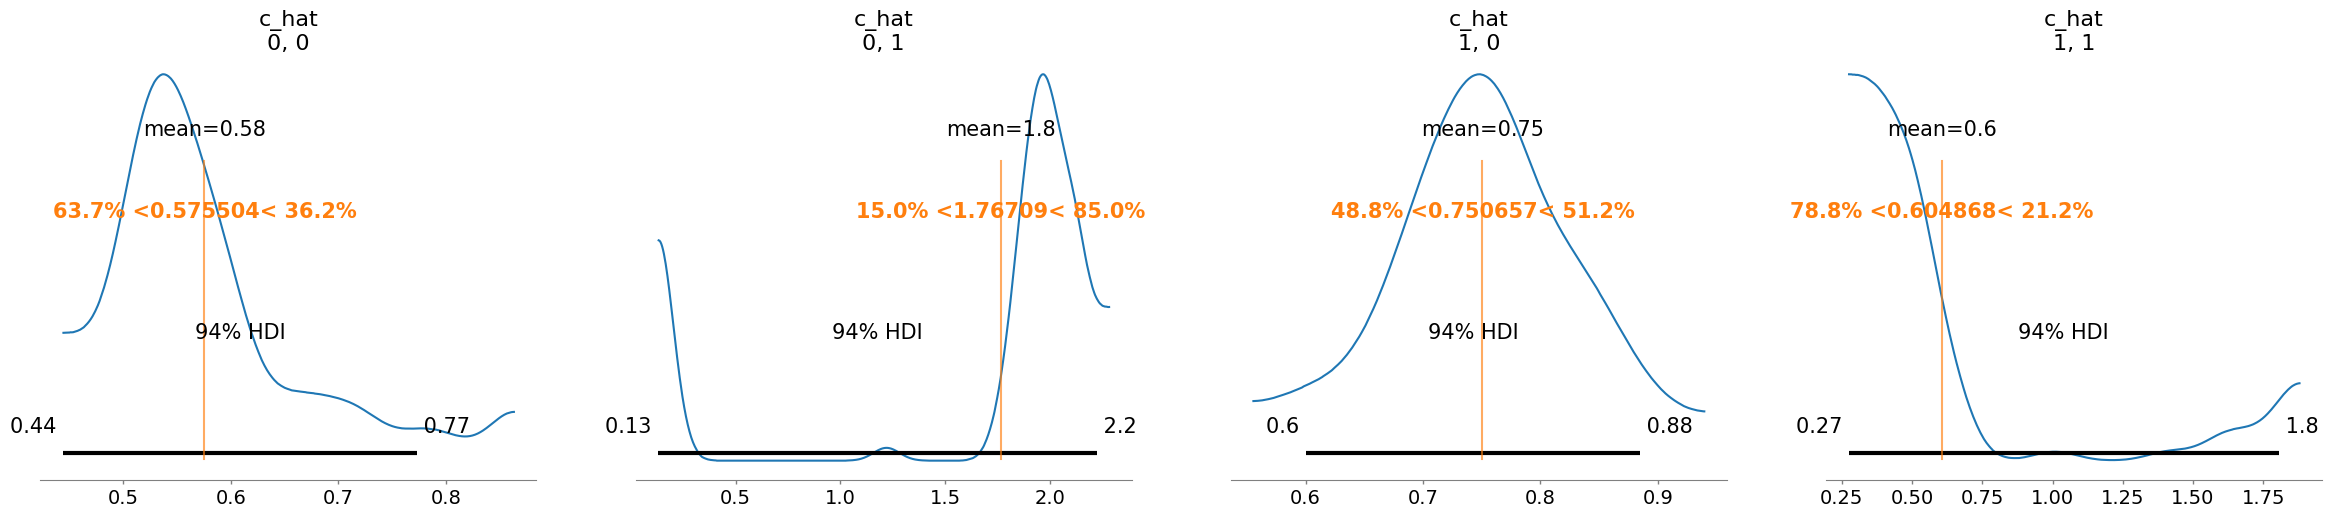

Parameter m_hat not found in posterior samples, skipping plot.
Parameter r_hat not found in posterior samples, skipping plot.
Parameter K_hat not found in posterior samples, skipping plot.
              mean     sd  r_hat
c_hat[0, 0]  0.576  0.089   1.43
c_hat[0, 1]  1.767  0.630   1.27
c_hat[1, 0]  0.751  0.076   1.20
c_hat[1, 1]  0.605  0.443   1.38
sigma[0]     2.806  0.102   1.18


'model_posterior.nc'

In [ ]:
num_species = 2
num_resources = 2

# fixed parameters
tau = params["tau"]
m = params["m"]
r = params["r"]
w = params["w"]
K = params["K"]

# Define prior for c (resource preference matrix)
prior_c_mean = 0.6     
prior_c_sigma = 0.5

# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

inference = inferCRMbayes()

inference.set_parameters(times=times, yobs=yobs, num_species=num_species, num_resources=num_resources,
                         tau=tau, m=m, r=r, w=w, K=K,
                         prior_c_mean=prior_c_mean, prior_c_sigma=prior_c_sigma,
                         draws=draws, tune=tune, chains=chains, cores=cores)

idata = inference.run_inference()

# To plot posterior distributions
inference.plot_posterior(idata)


summary = az.summary(idata, var_names=["c_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')




c_hat/c:
[[0.55 1.96]
 [0.75 0.45]]

 [[0.67557518 0.43848517]
 [0.88461136 0.64786379]]


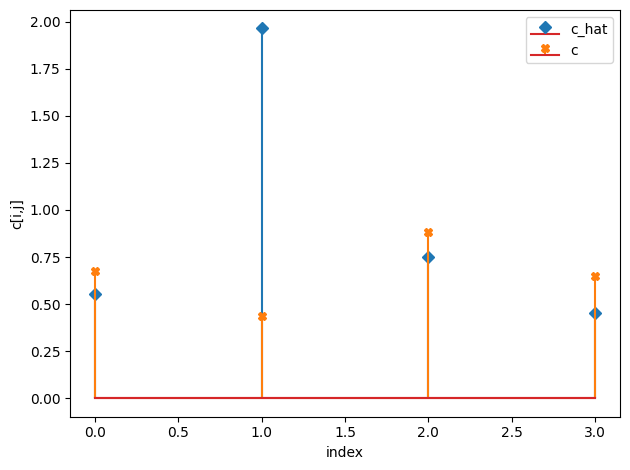

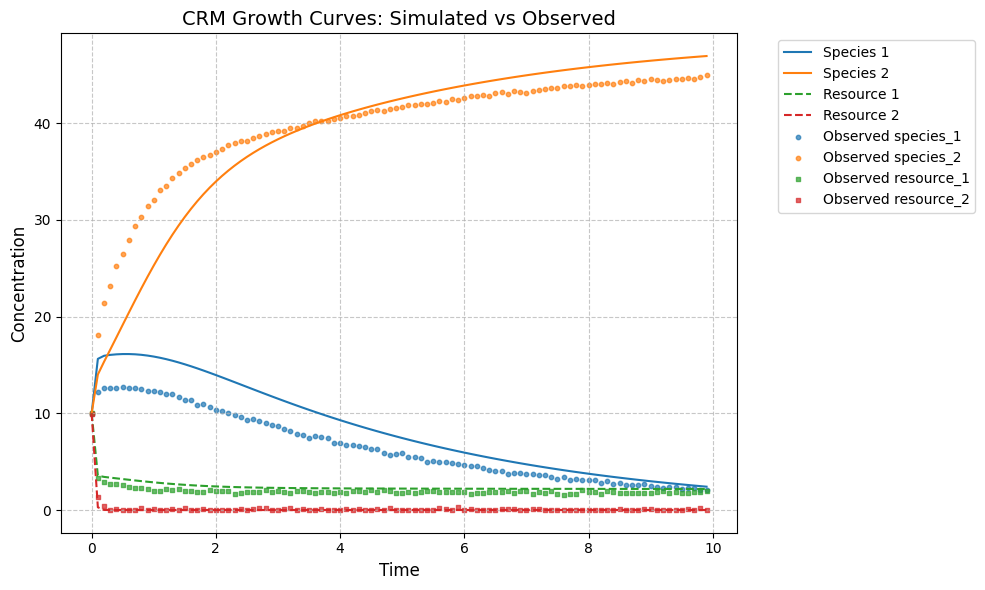

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'CRM Growth Curves: Simulated vs Observed'}, xlabel='Time', ylabel='Concentration'>)

In [11]:
# Plot the CRM

init_species = 10 * np.ones(num_species+num_resources)

# inferred parameters
c_h = np.median(idata.posterior["c_hat"].values, axis=(0,1) )

compare_params(c=(c, c_h))

predictor = sim_CRM()

predictor.set_parameters(num_species = num_species,
                         num_resources = num_resources,
                         tau = tau,
                         w = w,
                         c = c_h,
                         m = m,
                         r = r,
                         K = K)

#predictor.print_parameters()

observed_species, observed_resources = predictor.simulate(times, init_species)
observed_data = np.hstack((observed_species, observed_resources))
 
# plot predicted species and resouce dynamics against observed data

plot_CRM(observed_species, observed_resources, times, 'data-s2-r2.csv')

## Infer all parameters

In [ ]:
# read in pickled simulated parameters, tau, m, r, w, K and c
num_species = 2
num_resources = 2
with open("params-s2-r2.pkl", "rb") as f:
    params = pickle.load(f)
tau = params["tau"]
m = params["m"]
r = params["r"]
w = params["w"]
K = params["K"]
c = params["c"]

# read in the data

num_timecourses = 1
data = pd.read_csv("data-s2-r2.csv")

times = data.iloc[:, 0].values
yobs = data.iloc[:, 1:6].values



# Define priors
prior_tau_mean = 1.0   # species timescale vector
prior_tau_sigma = 0.5

prior_m_mean = 0.7     # mortality rate vector
prior_m_sigma = 0.5

prior_c_mean = 0.6     # resource preference matrix
prior_c_sigma = 0.5

prior_r_mean = 0.4      # resource timescale vector
prior_r_sigma = 0.5

prior_w_mean = 0.5     # resource quality vector
prior_w_sigma = 0.3

prior_K_mean = 1.5      # resource carrying capacity vector
prior_K_sigma = 1.0


# Sampling conditions
draws = 100
tune = 100
chains = 4
cores = 4

inference = inferCRMbayes()

inference.set_parameters(times=times, yobs=yobs, num_species=num_species, num_resources=num_resources,
                          prior_tau_mean=prior_tau_mean, prior_tau_sigma=prior_tau_sigma,
                          prior_m_mean=prior_m_mean, prior_m_sigma=prior_m_sigma,
                          prior_r_mean=prior_r_mean, prior_r_sigma=prior_r_sigma,
                          prior_w_mean=prior_w_mean, prior_w_sigma=prior_w_sigma,
                          prior_K_mean=prior_K_mean, prior_K_sigma=prior_K_sigma,
                          prior_c_mean=prior_c_mean, prior_c_sigma=prior_c_sigma,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference()


# To plot posterior distributions
#inference.plot_posterior(idata)

summary = az.summary(idata, var_names=["tau_hat", "w_hat", "c_hat", "m_hat", "r_hat", "K_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')



In [ ]:

# # compare fitted with simulated parameters
tau_h = np.median(idata.posterior["tau_hat"].values, axis=(0,1) ).reshape(-1)
m_h = np.median(idata.posterior["m_hat"].values, axis=(0,1) ).reshape(-1)
r_h = np.median(idata.posterior["r_hat"].values, axis=(0,1) ).reshape(-1)
w_h = np.median(idata.posterior["w_hat"].values, axis=(0,1) ).reshape(-1)
K_h = np.median(idata.posterior["K_hat"].values, axis=(0,1) ).reshape(-1)
c_h = np.median(idata.posterior["c_hat"].values, axis=(0,1) )


compare_params(tau=(tau, tau_h), m=(m, m_h), r=(r, r_h), w=(w, w_h), K=(K, K_h) , c=(c, c_h))

predictor = sim_CRM()

predictor.set_parameters(num_species = num_species,
                         num_resources = num_resources,
                         tau = tau_h,
                         w = w_h,
                         c = c_h,
                         m = m_h,
                         r = r_h,
                         K = K_h)

predictor.print_parameters()

observed_species, observed_resources = predictor.simulate(times, init_species)
observed_data = np.hstack((observed_species, observed_resources))
 
# plot simulated species and resouce dynamics

plot_CRM(observed_species, observed_resources, times)

# predictor = sim_CRM(num_species=num_species, num_resources=num_resources, tau=tau_h, m=m_h, r=r_h, w=w_h, K=K_h, c=c_h.T)
# yobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=yobs[0])
# plot_fit_gLV(yobs, yobs_h, times)

### Old notes

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def CRM(sy, t, nsp, nr, tau, w, c, m, r, K):
    # Separate species (N) and resources (R)
    N = sy[:nsp]
    R = sy[nsp:]

    # Changes in species (dN)
    dN = (N / tau) * (c @ (w * R) - m)

    # Changes in resources (dR)
    dR = (1 / r * K) * (K - R) * R - (N @ c * R)

    # Return derivative of species and resources
    return np.hstack((dN, dR))


# Parameters for the model
nsp = 2  # Number of species
nr = 2   # Number of resources


tau = np.random.uniform(0.1, 1.0, nsp)  # species timescales
w = np.random.uniform(0.1, 1.0, nr)    # resource quality
c = np.random.uniform(0.1, 1.0, (nsp, nr))  # relative resource preferences
m = np.random.uniform(0.1, 1.0, nsp)  # mortality rates
r = np.random.uniform(0.1, 1.0, nr)   # resource timescales
K = np.random.uniform(1.0, 10.0, nr)  # resource carrying capacities


# Initial conditions (N0 for species, R0 for resources)
N0 = np.array([5.0, 4.0])  # Initial species populations
R0 = np.array([50.0, 50.0])  # Initial resource amounts
sy0 = np.concatenate([N0, R0])  # Combined initial condition
init_species = 10 * np.ones(nsp + nr)


# Time points to solve the ODE
times = np.arange(0, 10, 0.1)

# Solve the system of ODEs
solution = odeint(CRM, init_species, times, args=(nsp, nr, tau, w, c, m, r, K))

# Extract species and resources from the solution
N_solution = solution[:, :nsp]  # Species population over time
R_solution = solution[:, nsp:]  # Resource levels over time

# Plot the results

plot_CRM(N_solution, R_solution, times)


In [ ]:

import numpy as np
import pymc as pm
from pymc.ode import DifferentialEquation

# Define the ODE function for CRM model
def CRM(y,t, p):
    # Unpack parameters from the vector p
    tau = p[:2]  # Species time scales (2 values)
    w = p[2:4]  # Resource quality (2 values)
    c_flat = p[4:8]  # Flattened resource preferences (4 values)
    c = c_flat.reshape((2, 2))  # Reshape to 2x2 matrix
    m = p[8:10]  # Mortality rates (2 values)
    r = p[10:12]  # Resource time scales (2 values)
    K = p[12:14]  # Resource carrying capacities (2 values)

    # Separate species (N) and resources (R)
    N = y[:2]  # Species populations (2 elements)
    R = y[2:]  # Resource availability (2 elements)

    
    # Species growth equation (dN)
    #dN = (N / tau) * (c @ (w * R) - m)  # Species growth equation

    growth_term = at.dot(c, w * R)  # Matrix multiplication for species-resource interaction
    dN = (N / tau) * (growth_term - m)  # Species growth equation

    # Resource consumption equation (dR)
    #dR = (1 / r * K) * (K - R) * R - (N @ c * R) # Resource consumption

    consumption_term = at.dot(N, c)  # Matrix multiplication for resource consumption by species
    dR = (1 / (r * K)) * (K - R) * R - consumption_term * R  # Resource consumption equation

    # Combine dN and dR into a single 1D array
    derivatives = [dN[0], dN[1], dR[0], dR[1]]  # Horizontal stacking ensures a 1D array
   

    # Return the derivatives for both species and resources as a single array
    #return np.concatenate([dN, dR])  # Concatenate to match n_states
    #return [dN,dR] 
    return derivatives  # Return as list

def CRM_numeric(y,t, p):
    # Unpack parameters from the vector p
    tau = p[:2]  # Species time scales (2 values)
    w = p[2:4]  # Resource quality (2 values)
    c_flat = p[4:8]  # Flattened resource preferences (4 values)
    c = c_flat.reshape((2, 2))  # Reshape to 2x2 matrix
    m = p[8:10]  # Mortality rates (2 values)
    r = p[10:12]  # Resource time scales (2 values)
    K = p[12:14]  # Resource carrying capacities (2 values)

    # Separate species (N) and resources (R)
    N = y[:2]  # Species populations (2 elements)
    R = y[2:]  # Resource availability (2 elements)


    #dN = (N / tau) * (c @ (w * R) - m)  # Species growth equation

    #dR = (1 / r * K) * (K - R) * R - (N @ c * R) # Resource consumption

    # Species growth equation (dN)
    growth_term = np.dot(c, w * R)  # Matrix multiplication for species-resource interaction
    dN = (N / tau) * (growth_term - m)  # Species growth equation

    # Resource consumption equation (dR)
    consumption_term = np.dot(N, c)  # Matrix multiplication for resource consumption by species
    dR = (1 / (r * K)) * (K - R) * R - consumption_term * R  # Resource consumption equation

    # Combine dN and dR into a single 1D array
    derivatives = [dN[0], dN[1], dR[0], dR[1]]  # Horizontal stacking ensures a 1D array
   

    # Return the derivatives for both species and resources as a single array
    #return np.concatenate([dN, dR])  # Concatenate to match n_states
    #return [dN,dR] 
    return derivatives  # Return as list
    

# Set up initial conditions and parameters
num_species = 2
num_resources = 2

# Define model parameters (totals for species and resources)
# Set initial values for parameters (these would be set as priors later on)
tau = np.random.uniform(0.1, 1.0, num_species)  # Species time scales (2 values)
w = np.random.uniform(0.1, 1.0, num_resources)  # Resource quality (2 values)
c = np.random.uniform(0.1, 1.0, (num_species, num_resources))  # Resource preferences (2x2 matrix)
c_flat = c.ravel()  # Flatten the matrix for PyMC input
m = np.random.uniform(0.1, 1.0, num_species)  # Mortality rates (2 values)
r = np.random.uniform(0.1, 1.0, num_resources)  # Resource time scales (2 values)
K = np.random.uniform(1.0, 10.0, num_resources)  # Resource carrying capacities (2 values)

# Store parameters in a single vector (flattened for PyMC input)
params = np.concatenate([tau, w, c_flat, m, r, K])

# Set initial conditions (initial populations of species and resources)
y0 = np.concatenate([np.ones(num_species), np.ones(num_resources)])  # Initial species and resource populations
initial_conditions = np.concatenate([np.array([5.0, 2.0]), np.array([8.0, 12.0])])


# Time points for integration
times = np.linspace(0, 10, 100)

from scipy.integrate import odeint
numeric_solution = odeint(CRM_numeric, y0=y0, t=times, args=(params,))
#plt.plot(times, numeric_solution)
#plt.show()

# Plot the solution
plt.plot(times, numeric_solution[:, 0], label='Species 1 (N1)')
plt.plot(times, numeric_solution[:, 1], label='Species 2 (N2)')
plt.plot(times, numeric_solution[:, 2], label='Resource 1 (R1)')
plt.plot(times, numeric_solution[:, 3], label='Resource 2 (R2)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()


# Define the DifferentialEquation model
crm_model = DifferentialEquation(
    func=CRM,  # The ODE function
    times=times,  # Time points for the solution
    n_states=num_species+num_resources,  # Total state variables (2 species + 2 resources)
    n_theta=len(params),  # Total number of parameters (tau, w, c, m, r, K)
    t0=0  # Initial time
)






In [ ]:
nr = num_resources
nsp = num_species
n_states = nsp + nr

with pm.Model() as model:
    # Priors for the parameters
    sigma = pm.HalfCauchy("sigma", 1, shape=n_states)  
    
    tau = pm.Normal("tau", mu=1.0, sigma=0.5, shape=nsp)
    w = pm.Normal("w", mu=1.0, sigma=0.2, shape=nr)
    c = pm.Normal("c", mu=0.5, sigma=0.1, shape=(nsp, nr))
    m = pm.Normal("m", mu=0.1, sigma=0.05, shape=nsp)
    r = pm.Normal("r", mu=1.0, sigma=0.1, shape=nr)
    K = pm.Normal("K", mu=10.0, sigma=5.0, shape=nr)

    # Pack parameters into a single vector
    theta = at.concatenate([tau, w, c.flatten(), m, r, K])

    # Initial conditions for the ODE
    initial_conditions = np.concatenate([np.array([10.0, 10.0]), np.array([8.0, 12.0])])
    y0 = np.concatenate([np.ones(num_species), np.ones(num_resources)])  # Initial species and resource populations

    # Solve the ODE
    crm_curves = crm_model(y0=y0, theta=theta)

    #print('numeric_solution shape:', numeric_solution)

    # Define the likelihood
    Y = pm.Lognormal("Y", mu=at.log(crm_curves), sigma=sigma, observed=numeric_solution)

    # Sample the posterior
    data = pm.sample(draws = 50, tune=50, chains=8, cores=8)

az.plot_posterior(data)

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE function for CRM model
def CRM(y, t, p):
    # Unpack parameters from the vector p
    tau = p[:2]  # Species time scales (2 values)
    w = p[2:4]   # Resource quality (2 values)
    c_flat = p[4:8]  # Flattened resource preferences (4 values)
    c = c_flat.reshape((2, 2))  # Reshape to 2x2 matrix
    m = p[8:10]  # Mortality rates (2 values)
    r = p[10:12]  # Resource time scales (2 values)
    K = p[12:14]  # Resource carrying capacities (2 values)

    # Separate species (N) and resources (R)
    N = y[:2]  # Species populations (2 elements)
    R = y[2:]  # Resource availability (2 elements)

    # Define the ODEs
    dN = (N / tau) * (np.dot(c, w * R) - m)  # Species growth equation
    dR = (1 / (r * K)) * (K - R) * R - np.dot(N, c) * R  # Resource consumption

    # Return the concatenated derivatives
    return np.concatenate([dN, dR])

# Set initial conditions and parameters
num_species = 2
num_resources = 2

# Define model parameters (totals for species and resources)
tau = np.random.uniform(0.1, 1.0, num_species)  # Species time scales (2 values)
w = np.random.uniform(0.1, 1.0, num_resources)  # Resource quality (2 values)
c = np.random.uniform(0.1, 1.0, (num_species, num_resources))  # Resource preferences (2x2 matrix)
c_flat = c.ravel()  # Flatten the matrix for PyMC input
m = np.random.uniform(0.1, 1.0, num_species)  # Mortality rates (2 values)
r = np.random.uniform(0.1, 1.0, num_resources)  # Resource time scales (2 values)
K = np.random.uniform(1.0, 10.0, num_resources)  # Resource carrying capacities (2 values)

# Store parameters in a single vector (flattened for PyMC input)
params = np.concatenate([tau, w, c_flat, m, r, K])

# Set initial conditions (initial populations of species and resources)
y0 = np.concatenate([np.ones(num_species), np.ones(num_resources)])  # Initial species and resource populations

# Time points for integration
times = np.linspace(0, 10, 100)

# Solve the ODE using odeint
solution = odeint(CRM, y0=y0, t=times, args=(params,))

# Plot the solution
plt.plot(times, solution[:, 0], label='Species 1 (N1)')
plt.plot(times, solution[:, 1], label='Species 2 (N2)')
plt.plot(times, solution[:, 2], label='Resource 1 (R1)')
plt.plot(times, solution[:, 3], label='Resource 2 (R2)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()


In [4]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from pymc.ode import DifferentialEquation

# Define the CRM ODE function (already provided)
def CRM(y, t, p):
    # Unpack parameters
    tau = p[:2]  # Species time scales
    w = p[2:4]  # Resource quality
    c_flat = p[4:8]  # Resource preferences flattened
    c = c_flat.reshape((2, 2))  # Reshape to matrix form
    m = p[8:10]  # Mortality rates
    r = p[10:12]  # Resource time scales
    K = p[12:14]  # Resource carrying capacities

    N = y[:2]  # Species populations
    R = y[2:]  # Resource availability

    growth_term = np.dot(c, w * R)  # Interaction term
    dN = (N / tau) * (growth_term - m)  # Species growth equation

    consumption_term = np.dot(N, c)  # Consumption term
    dR = (1 / (r * K)) * (K - R) * R - consumption_term * R  # Resource equation

    # Return the derivatives as a single list (flattened)
    return np.concatenate([dN, dR])

# Time points for ODE integration
times = np.linspace(0, 10, 100)

# Initial conditions and parameters (same as earlier)
num_species = 2
num_resources = 2
y0 = np.concatenate([np.ones(num_species), np.ones(num_resources)])  # Initial populations

# Generate model parameters
tau = np.random.uniform(0.1, 1.0, num_species)
w = np.random.uniform(0.1, 1.0, num_resources)
c = np.random.uniform(0.1, 1.0, (num_species, num_resources))
c_flat = c.ravel()
m = np.random.uniform(0.1, 1.0, num_species)
r = np.random.uniform(0.1, 1.0, num_resources)
K = np.random.uniform(1.0, 10.0, num_resources)
params = np.concatenate([tau, w, c_flat, m, r, K])

# Solve the system numerically
from scipy.integrate import odeint
numeric_solution = odeint(CRM_numeric, y0=y0, t=times, args=(params,))

# Plot the solution
plt.plot(times, numeric_solution[:, 0], label='Species 1 (N1)')
plt.plot(times, numeric_solution[:, 1], label='Species 2 (N2)')
plt.plot(times, numeric_solution[:, 2], label='Resource 1 (R1)')
plt.plot(times, numeric_solution[:, 3], label='Resource 2 (R2)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()


NameError: name 'CRM_numeric' is not defined